### In|OUT vs BAD

/tmp/ipykernel_16164/1223248370.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['label_inout_bad'] = clean_df[INTEREST_LABEL].apply(lambda x: 'IN_OUT' if x in ['IN', 'OUT'] else 'BAD')
/tmp/ipykernel_16164/1223248370.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['label_inout_bad_encoded'] = label_encoder.fit_transform(train_df['label_inout_bad'])


Validation Accuracy: 1.0
LabelEncoder classes: ['BAD' 'IN_OUT']
LabelEncoder inverse transform: ['IN_OUT' 'BAD']
Updated CSV saved successfully.


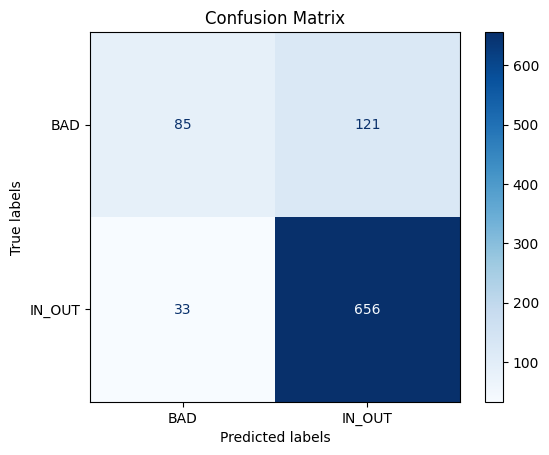

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from utils import aggregate_and_compare_predictions, plot_confusion_matrix, plot_false_positives, calculate_confidence_distribution

BASE_IMAGES_PATH = '/home/diego/Documents/yolov7-tracker/imgs_conce'
BASE_FOLDER_NAME = 'results'
FILE_NAME = '130_conce_bbox.csv'
CSV_FILE_PATH = os.path.join(BASE_FOLDER_NAME, FILE_NAME)
INTEREST_LABEL = 'label_direction'

MODEL_RESULT = os.path.join(BASE_FOLDER_NAME, f'model_inout_vs_bad_{FILE_NAME}')

df = pd.read_csv(CSV_FILE_PATH)


# Remover todos los blanks en label_direction
# Transformar label_direction en 1 para IN y OUT y 0 para BAD

clean_df = df.dropna(subset=[INTEREST_LABEL])
clean_df['label_inout_bad'] = clean_df[INTEREST_LABEL].apply(lambda x: 'IN_OUT' if x in ['IN', 'OUT'] else 'BAD')


train_df = clean_df[(clean_df['id'] < 1300)]
predict_df = clean_df[(clean_df['id'] >= 1300)]

label_encoder = LabelEncoder()
train_df['label_inout_bad_encoded'] = label_encoder.fit_transform(train_df['label_inout_bad']) 


not_imporant_features = ['id',
                         INTEREST_LABEL,
                         'label_inout_bad',
                         'label_inout_bad_encoded',
                         'conf_score',
                         'k_fold',
                         'label_img',
                         'overlap',
                         'area',
                         'frame_number',
                         ]
# Define features (make sure to only include numeric columns and exclude any text columns)
features = [col for col in train_df.columns if col not in not_imporant_features and train_df[col].dtype in [np.int64, np.float64]]
target = 'label_inout_bad_encoded'

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(train_df[features], train_df[target], test_size=0.2, random_state=42)

# Initialize the Gradient Boosting Classifier
model = GradientBoostingClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

##################################################################
# Predict on the test set
val_predictions = model.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {val_accuracy}")



predict_df = predict_df.dropna(subset=features)
# Predicting on the dataset without labels
predict_features = predict_df[features]
predicted_labels = model.predict(predict_features)
predicted_confidences = model.predict_proba(predict_features).max(axis=1)

# Adding predictions back to the dataframe
predict_df['model_label_good_direction'] = predicted_labels
predict_df['model_label_good_direction_conf'] = predicted_confidences
predict_df['model_label_good_direction'] = label_encoder.inverse_transform(predict_df['model_label_good_direction'].astype(int))

# Combine the prediction and training dataframes
final_df = pd.concat([train_df, predict_df], sort=False)

# Save the updated dataframe to a new CSV file
final_df.to_csv(MODEL_RESULT, index=False) 

print("LabelEncoder classes:", label_encoder.classes_)
print("LabelEncoder inverse transform:", label_encoder.inverse_transform([1,0]))
print("Updated CSV saved successfully.")

################################################ TESTING ################################################
agg_df = aggregate_and_compare_predictions(final_df, 'model_label_good_direction', 'label_inout_bad')
plot_confusion_matrix(agg_df)

### 50 / 50 Ratio

/tmp/ipykernel_14346/3633732745.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['label_inout_bad'] = clean_df[INTEREST_LABEL].apply(lambda x: 'IN_OUT' if x in ['IN', 'OUT'] else 'BAD')


Validation Accuracy: 0.7
LabelEncoder classes: ['BAD' 'IN_OUT']
LabelEncoder inverse transform: ['IN_OUT' 'BAD']
Updated CSV saved successfully.


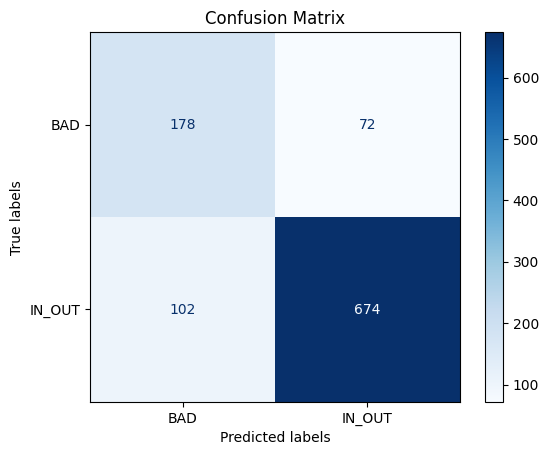

In [12]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from utils import aggregate_and_compare_predictions, plot_confusion_matrix, plot_false_positives, calculate_confidence_distribution

BASE_IMAGES_PATH = '/home/diego/Documents/yolov7-tracker/imgs_conce'
BASE_FOLDER_NAME = 'results'
FILE_NAME = '130_conce_bbox.csv'
CSV_FILE_PATH = os.path.join(BASE_FOLDER_NAME, FILE_NAME)
INTEREST_LABEL = 'label_direction'

MODEL_RESULT = os.path.join(BASE_FOLDER_NAME, f'model_inout_vs_bad_{FILE_NAME}')

# Load the DataFrame
df = pd.read_csv(CSV_FILE_PATH)

# Define your INTEREST_LABEL column name
INTEREST_LABEL = 'label_direction'  # Adjust based on your actual column name

# Clean the DataFrame
clean_df = df.dropna(subset=[INTEREST_LABEL])
clean_df['label_inout_bad'] = clean_df[INTEREST_LABEL].apply(lambda x: 'IN_OUT' if x in ['IN', 'OUT'] else 'BAD')

# Split the cleaned DataFrame into two based on label_inout_bad
df_in_out = clean_df[clean_df['label_inout_bad'] == 'IN_OUT']
df_bad = clean_df[clean_df['label_inout_bad'] == 'BAD']

# Randomly sample 50 entries for each case
df_in_out_sample = df_in_out.sample(n=50, random_state=42)
df_bad_sample = df_bad.sample(n=50, random_state=42)

# Combine the samples to form the training dataset
train_df = pd.concat([df_in_out_sample, df_bad_sample])

# Make sure to select the prediction set from the cleaned data excluding the training set
predict_df = clean_df.drop(train_df.index)

# Proceed with encoding and feature selection
label_encoder = LabelEncoder()
train_df['label_inout_bad_encoded'] = label_encoder.fit_transform(train_df['label_inout_bad'])

# Define not important features list, adjust as per your specific column names
not_important_features = ['id', INTEREST_LABEL, 'label_inout_bad', 'label_inout_bad_encoded', 'conf_score', 'k_fold', 'label_img', 'overlap', 'area', 'frame_number']

# Define features (excluding non-numeric and not important features)
features = [col for col in train_df.columns if col not in not_important_features and train_df[col].dtype in [np.int64, np.float64]]
target = 'label_inout_bad_encoded'

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(train_df[features], train_df[target], test_size=0.2, random_state=42)

# Initialize the Gradient Boosting Classifier
model = GradientBoostingClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

##################################################################
# Predict on the test set
val_predictions = model.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {val_accuracy}")



predict_df = predict_df.dropna(subset=features)
# Predicting on the dataset without labels
predict_features = predict_df[features]
predicted_labels = model.predict(predict_features)
predicted_confidences = model.predict_proba(predict_features).max(axis=1)

# Adding predictions back to the dataframe
predict_df['model_label_good_direction'] = predicted_labels
predict_df['model_label_good_direction_conf'] = predicted_confidences
predict_df['model_label_good_direction'] = label_encoder.inverse_transform(predict_df['model_label_good_direction'].astype(int))

# Combine the prediction and training dataframes
final_df = pd.concat([train_df, predict_df], sort=False)

# Save the updated dataframe to a new CSV file
final_df.to_csv(MODEL_RESULT, index=False) 

print("LabelEncoder classes:", label_encoder.classes_)
print("LabelEncoder inverse transform:", label_encoder.inverse_transform([1,0]))
print("Updated CSV saved successfully.")

################################################ TESTING ################################################
agg_df = aggregate_and_compare_predictions(final_df, 'model_label_good_direction', 'label_inout_bad')
plot_confusion_matrix(agg_df)